# Within-Window Temporal Dynamics Analysis

**Purpose**: Analyze WHEN within the PRE-decision window (-2s to 0s) physiological and gaze signals diverge between INVEST vs KEEP decisions.

**Key Question**: How early can we detect the upcoming decision from pupil and gaze patterns?

**Method**:
1. Divide the PRE-decision window into sub-windows (e.g., 500ms bins)
2. Extract features within each sub-window
3. Test for significant divergence at each time point
4. Visualize the temporal evolution of effect sizes

In [5]:
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Configuration

In [6]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Time window settings
WINDOW_START = -2.0  # seconds before submit
WINDOW_END = 0.0     # at submit
BIN_SIZE = 0.5       # 500ms bins

# Generate time bins
TIME_BINS = []
t = WINDOW_START
while t < WINDOW_END:
    TIME_BINS.append((t, min(t + BIN_SIZE, WINDOW_END)))
    t += BIN_SIZE

print(f"Analysis window: {WINDOW_START}s to {WINDOW_END}s")
print(f"Bin size: {BIN_SIZE}s")
print(f"Time bins: {TIME_BINS}")

# Paths
PREPROCESSING_DIR = Path('../../data/results/preprocessing_outputs/preprocessing')
RAW_DIR = Path('../../data/raw/json')
OUTPUT_DIR = Path('../../data/results/analysis_outputs_PRE')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BASELINE_METHOD = 't3_stable_pre_decision'

Analysis window: -2.0s to 0.0s
Bin size: 0.5s
Time bins: [(-2.0, -1.5), (-1.5, -1.0), (-1.0, -0.5), (-0.5, 0.0)]


## 2. Load and Process Raw Pupil Time Series

We need to extract pupil features for each time bin separately.

In [7]:
def extract_pupil_features_for_bin(pupil_data, time_data, time_bin):
    """
    Extract all pupil features for a specific time bin.
    
    Parameters
    ----------
    pupil_data : array
        Baselined pupil values
    time_data : array
        Time relative to submit (seconds)
    time_bin : tuple
        (start, end) time in seconds
    
    Returns
    -------
    dict or None
        Dictionary of features, or None if insufficient data
    """
    # Filter to time bin
    mask = (time_data >= time_bin[0]) & (time_data < time_bin[1])
    pupil = pupil_data[mask]
    time_filtered = time_data[mask]
    
    if len(pupil) < 3:  # Need minimum samples
        return None
    
    # Calculate derivatives
    pupil_velocity = np.diff(pupil) if len(pupil) > 1 else np.array([0])
    pupil_acceleration = np.diff(pupil_velocity) if len(pupil_velocity) > 1 else np.array([0])
    dilation_mask = pupil_velocity > 0 if len(pupil_velocity) > 0 else np.array([False])
    
    features = {
        # Central tendency
        'pupil_mean': np.mean(pupil),
        'pupil_median': np.median(pupil),
        
        # Variability
        'pupil_std': np.std(pupil),
        'pupil_range': np.max(pupil) - np.min(pupil),
        'pupil_cv': np.std(pupil) / np.abs(np.mean(pupil)) if np.mean(pupil) != 0 else 0,
        
        # Trend
        'pupil_slope': np.polyfit(time_filtered, pupil, 1)[0] if len(time_filtered) > 1 else 0,
        
        # Velocity metrics
        'pupil_velocity_mean': np.mean(np.abs(pupil_velocity)) if len(pupil_velocity) > 0 else 0,
        'pupil_velocity_std': np.std(pupil_velocity) if len(pupil_velocity) > 0 else 0,
        'pupil_max_dilation_rate': np.max(pupil_velocity) if len(pupil_velocity) > 0 else 0,
        'pupil_max_constriction_rate': np.abs(np.min(pupil_velocity)) if len(pupil_velocity) > 0 else 0,
        
        # Acceleration
        'pupil_acceleration_mean': np.mean(np.abs(pupil_acceleration)) if len(pupil_acceleration) > 0 else 0,
        'pupil_acceleration_std': np.std(pupil_acceleration) if len(pupil_acceleration) > 1 else 0,
        
        # Dilation patterns
        'pct_time_dilating': np.mean(dilation_mask) if len(dilation_mask) > 0 else 0,
        'num_dilation_peaks': np.sum(np.diff(np.sign(pupil_velocity)) > 0) if len(pupil_velocity) > 1 else 0,
        
        # Min/Max
        'pupil_min': np.min(pupil),
        'pupil_max': np.max(pupil),
    }
    
    return features

print("Feature extraction function defined")

Feature extraction function defined


In [8]:
import re

# Load all preprocessing files and extract features per time bin
preprocessing_files = sorted(PREPROCESSING_DIR.glob('preprocessing_*.json'))
print(f"Found {len(preprocessing_files)} preprocessing files")

# Load outcomes from already-extracted features
import pickle
with open('../../data/results/features_PRE/extracted_features_PRE.pkl', 'rb') as f:
    feature_data = pickle.load(f)

outcomes_df = feature_data['merged_df'][['subject_id', 'trial_id', 'outcome']].copy()
# Create lookup: trial_id -> outcome
# trial_id format is like "4_0806_1000_539136F" 
outcome_lookup = dict(zip(outcomes_df['trial_id'], outcomes_df['outcome']))
print(f"Loaded outcomes for {len(outcome_lookup)} trials")

# Storage for all trials
all_trials_data = []

for preprocessed_file in tqdm(preprocessing_files, desc="Processing subjects"):
    with open(preprocessed_file, 'r') as f:
        preprocessed = json.load(f)
    
    subject_id = preprocessed['subject_id']
    
    for trial_id, trial_data in preprocessed['trial_data'].items():
        method_data = trial_data['methods'][BASELINE_METHOD]
        
        if method_data['success'] != True:
            continue
        
        # Get outcome from lookup
        lookup_key = f"{trial_id}_{subject_id}"
        if lookup_key not in outcome_lookup:
            continue
        
        outcome = outcome_lookup[lookup_key]
        
        # Extract pupil data
        # Note: time_relative_to_submit is already in seconds
        time_aligned = np.array(trial_data['time_relative_to_submit'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])
        
        # Clean NaN values
        valid_mask = ~np.isnan(pupil_avg)
        pupil_avg_clean = pupil_avg[valid_mask]
        pupil_L_clean = pupil_L[valid_mask]
        pupil_R_clean = pupil_R[valid_mask]
        time_clean = time_aligned[valid_mask]
        
        if len(pupil_avg_clean) < 20:
            continue
        
        # Extract features for each time bin
        trial_row = {
            'subject_id': subject_id,
            'trial_id': trial_id,
            'outcome': outcome
        }
        
        valid_bins = 0
        for bin_idx, time_bin in enumerate(TIME_BINS):
            bin_features = extract_pupil_features_for_bin(pupil_avg_clean, time_clean, time_bin)
            
            if bin_features is not None:
                valid_bins += 1
                for feat_name, feat_val in bin_features.items():
                    trial_row[f'{feat_name}_bin{bin_idx}'] = feat_val
            
            # Also compute eye asymmetry for this bin
            bin_mask = (time_clean >= time_bin[0]) & (time_clean < time_bin[1])
            L_bin = pupil_L_clean[bin_mask]
            R_bin = pupil_R_clean[bin_mask]
            if len(L_bin) > 0:
                trial_row[f'eye_asymmetry_bin{bin_idx}'] = np.nanmean(np.abs(L_bin - R_bin))
                trial_row[f'eye_asymmetry_std_bin{bin_idx}'] = np.nanstd(L_bin - R_bin)
        
        if valid_bins == len(TIME_BINS):  # Only keep trials with all bins
            all_trials_data.append(trial_row)

# Create DataFrame
df = pd.DataFrame(all_trials_data)
print(f"\nTotal trials with complete time bins: {len(df)}")
print(f"Subjects: {df['subject_id'].nunique()}")
print(f"\nOutcome distribution:")
print(df['outcome'].value_counts())

Found 99 preprocessing files
Loaded outcomes for 11467 trials


Processing subjects: 100%|██████████| 99/99 [00:18<00:00,  5.35it/s]



Total trials with complete time bins: 9483
Subjects: 97

Outcome distribution:
outcome
1    5979
0    3504
Name: count, dtype: int64


## 3. Temporal Divergence Analysis

For each feature and time bin, compute effect sizes and significance.

In [9]:
def compute_cohens_d(group1, group2):
    """Compute Cohen's d effect size."""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    if pooled_std == 0:
        return 0
    return (group1.mean() - group2.mean()) / pooled_std

# List of pupil features to analyze
PUPIL_FEATURES = [
    'pupil_mean',
    'pupil_median',
    'pupil_std',
    'pupil_range',
    'pupil_cv',
    'pupil_slope',
    'pupil_velocity_mean',
    'pupil_velocity_std',
    'pupil_max_dilation_rate',
    'pupil_max_constriction_rate',
    'pupil_acceleration_mean',
    'pupil_acceleration_std',
    'pct_time_dilating',
    'num_dilation_peaks',
    'pupil_min',
    'pupil_max',
    'eye_asymmetry',
    'eye_asymmetry_std',
]

# Separate by outcome
invest_trials = df[df['outcome'] == 1]
keep_trials = df[df['outcome'] == 0]

print(f"INVEST trials: {len(invest_trials)}")
print(f"KEEP trials: {len(keep_trials)}")

INVEST trials: 5979
KEEP trials: 3504


In [10]:
# Compute statistics for each feature at each time bin
temporal_results = []

for feature in PUPIL_FEATURES:
    for bin_idx, time_bin in enumerate(TIME_BINS):
        col_name = f'{feature}_bin{bin_idx}'
        
        if col_name not in df.columns:
            continue
        
        invest_vals = invest_trials[col_name].dropna()
        keep_vals = keep_trials[col_name].dropna()
        
        if len(invest_vals) < 10 or len(keep_vals) < 10:
            continue
        
        # T-test
        t_stat, p_val = stats.ttest_ind(invest_vals, keep_vals)
        
        # Effect size
        cohens_d = compute_cohens_d(invest_vals, keep_vals)
        
        temporal_results.append({
            'feature': feature,
            'bin_idx': bin_idx,
            'time_start': time_bin[0],
            'time_end': time_bin[1],
            'time_label': f"{time_bin[0]:.1f}s to {time_bin[1]:.1f}s",
            'invest_mean': invest_vals.mean(),
            'keep_mean': keep_vals.mean(),
            'difference': invest_vals.mean() - keep_vals.mean(),
            't_statistic': t_stat,
            'p_value': p_val,
            'cohens_d': cohens_d,
            'abs_cohens_d': abs(cohens_d),
            'significant': p_val < 0.05,
            'significant_bonferroni': p_val < (0.05 / (len(PUPIL_FEATURES) * len(TIME_BINS)))
        })

temporal_df = pd.DataFrame(temporal_results)
print(f"Computed {len(temporal_df)} feature-bin combinations")

Computed 72 feature-bin combinations


In [11]:
# Show strongest effects per time bin
print("\n" + "="*90)
print("STRONGEST EFFECTS BY TIME BIN (sorted by |Cohen's d|)")
print("="*90)

for bin_idx, time_bin in enumerate(TIME_BINS):
    bin_data = temporal_df[temporal_df['bin_idx'] == bin_idx].sort_values('abs_cohens_d', ascending=False)
    print(f"\n--- Time Bin {bin_idx}: {time_bin[0]:.1f}s to {time_bin[1]:.1f}s ---")
    print(bin_data[['feature', 'cohens_d', 'p_value', 'significant']].head(5).to_string(index=False))


STRONGEST EFFECTS BY TIME BIN (sorted by |Cohen's d|)

--- Time Bin 0: -2.0s to -1.5s ---
           feature  cohens_d      p_value  significant
        pupil_mean  0.145838 7.587786e-12         True
      pupil_median  0.143956 1.398893e-11         True
         pupil_min  0.133323 3.852431e-10         True
         pupil_max  0.129012 1.379242e-09         True
num_dilation_peaks -0.055150 9.551282e-03         True

--- Time Bin 1: -1.5s to -1.0s ---
                    feature  cohens_d      p_value  significant
pupil_max_constriction_rate  0.124812 4.599335e-09         True
                  pupil_max  0.121838 1.055134e-08         True
                pupil_slope -0.119670 1.909583e-08         True
          pct_time_dilating -0.117035 3.875768e-08         True
                pupil_range  0.109989 2.391355e-07         True

--- Time Bin 2: -1.0s to -0.5s ---
          feature  cohens_d  p_value  significant
pct_time_dilating -0.088909 0.000030         True
        pupil_max -0.08

## 4. Visualize Temporal Evolution of Effect Sizes

Create plots showing how effect sizes evolve across time bins.

In [12]:
# Plot effect sizes over time for top features
# Identify features with strongest overall effects
feature_avg_effect = temporal_df.groupby('feature')['abs_cohens_d'].mean().sort_values(ascending=False)
top_features = feature_avg_effect.head(8).index.tolist()

print("Top 8 features by average effect size:")
for i, feat in enumerate(top_features, 1):
    print(f"  {i}. {feat}: |d| = {feature_avg_effect[feat]:.3f}")

Top 8 features by average effect size:
  1. pupil_max: |d| = 0.109
  2. pupil_mean: |d| = 0.108
  3. pupil_median: |d| = 0.105
  4. pupil_min: |d| = 0.083
  5. pupil_slope: |d| = 0.062
  6. pupil_max_constriction_rate: |d| = 0.058
  7. pct_time_dilating: |d| = 0.052
  8. pupil_velocity_mean: |d| = 0.051


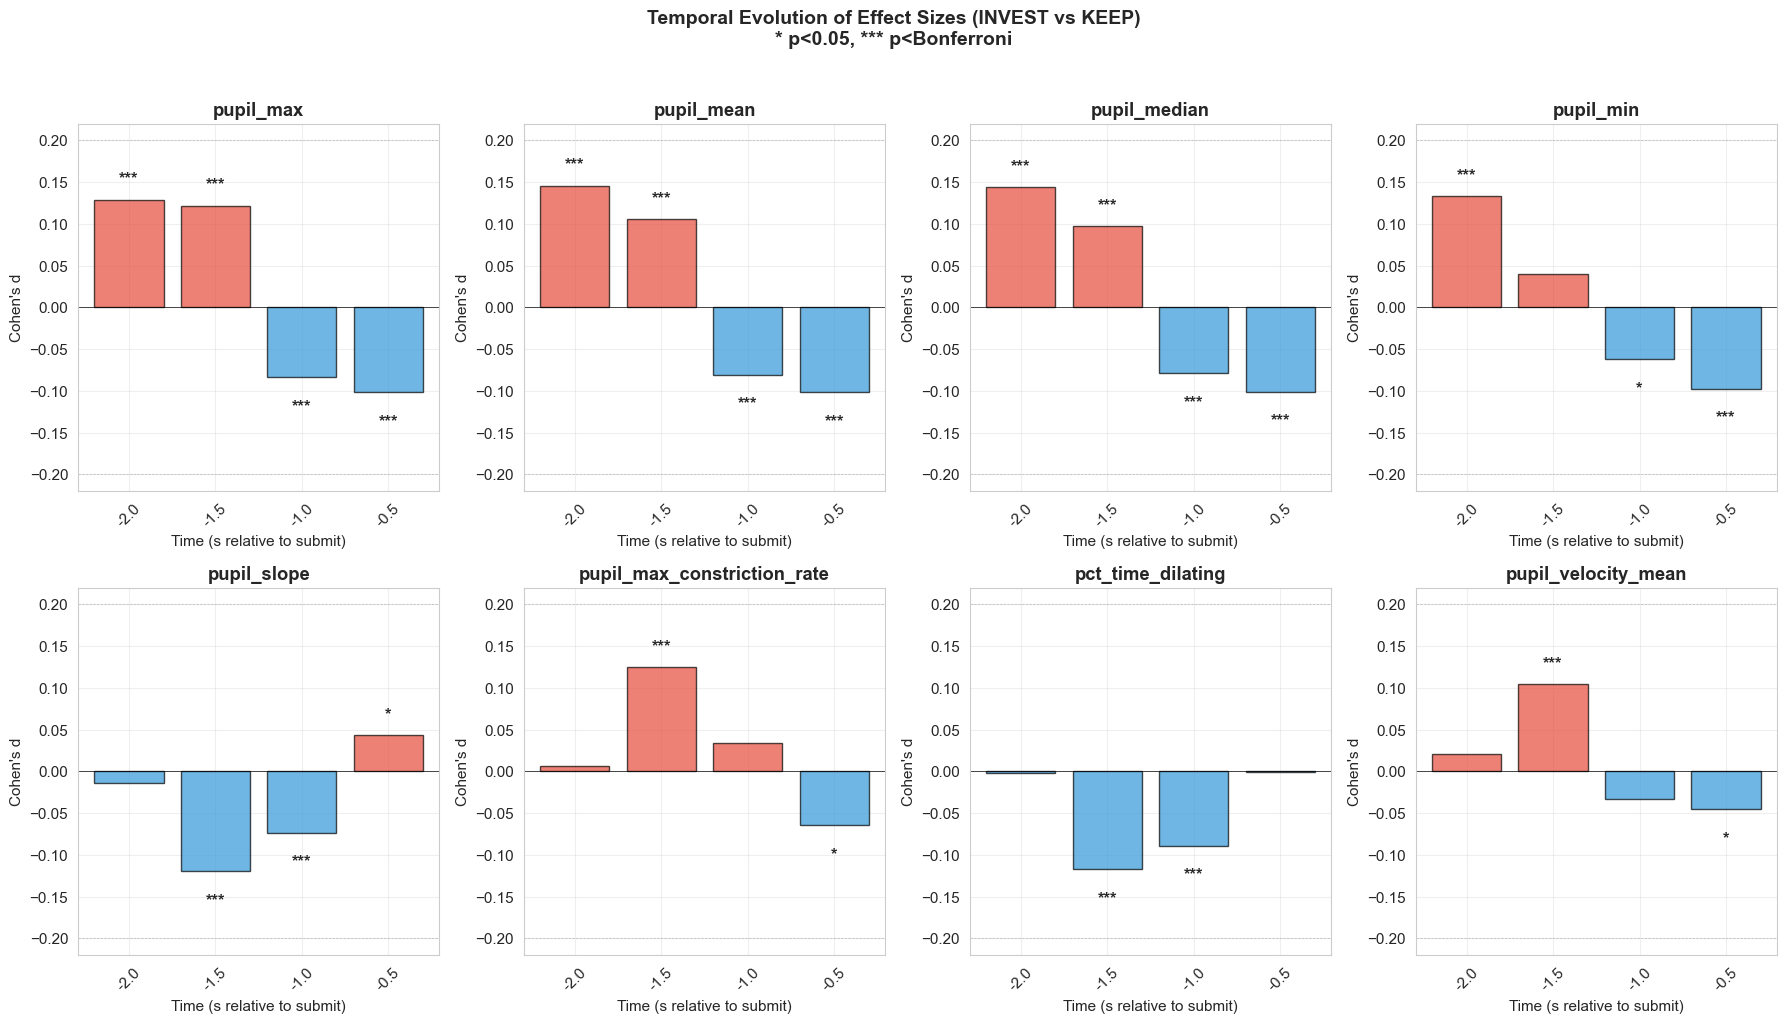

In [13]:
# Create temporal evolution plot
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

# Create x-axis labels from time bins
x_labels = [f"{tb[0]:.1f}" for tb in TIME_BINS]
x_positions = range(len(TIME_BINS))

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    feat_data = temporal_df[temporal_df['feature'] == feature].sort_values('bin_idx')
    
    # Plot effect size
    colors = ['#E74C3C' if d > 0 else '#3498DB' for d in feat_data['cohens_d']]
    bars = ax.bar(x_positions, feat_data['cohens_d'], color=colors, alpha=0.7, edgecolor='black')
    
    # Add significance markers
    for i, (_, row) in enumerate(feat_data.iterrows()):
        if row['significant_bonferroni']:
            y_pos = row['cohens_d'] + 0.02 if row['cohens_d'] > 0 else row['cohens_d'] - 0.04
            ax.text(i, y_pos, '***', ha='center', fontsize=12, fontweight='bold')
        elif row['significant']:
            y_pos = row['cohens_d'] + 0.02 if row['cohens_d'] > 0 else row['cohens_d'] - 0.04
            ax.text(i, y_pos, '*', ha='center', fontsize=12, fontweight='bold')
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axhline(y=0.2, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axhline(y=-0.2, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_xlabel('Time (s relative to submit)')
    ax.set_ylabel("Cohen's d")
    ax.set_title(feature, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Temporal Evolution of Effect Sizes (INVEST vs KEEP)\n* p<0.05, *** p<Bonferroni', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_evolution_effect_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

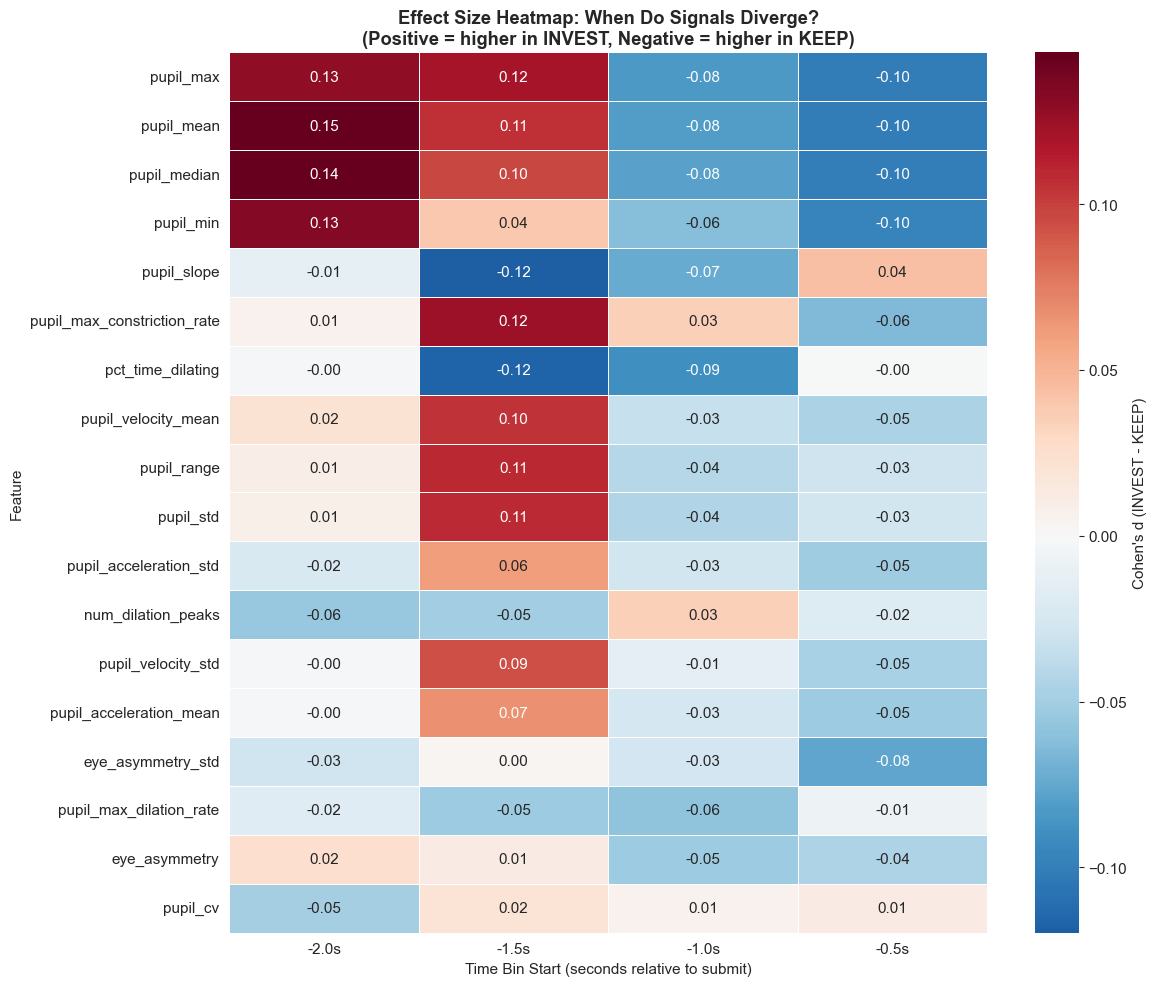

In [14]:
# Heatmap of all features over time
pivot_df = temporal_df.pivot(index='feature', columns='bin_idx', values='cohens_d')
pivot_df.columns = [f"{TIME_BINS[i][0]:.1f}s" for i in pivot_df.columns]

# Sort by average absolute effect
pivot_df['avg_abs'] = pivot_df.abs().mean(axis=1)
pivot_df = pivot_df.sort_values('avg_abs', ascending=False).drop('avg_abs', axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_df, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': "Cohen's d (INVEST - KEEP)"},
            linewidths=0.5)
plt.xlabel('Time Bin Start (seconds relative to submit)')
plt.ylabel('Feature')
plt.title('Effect Size Heatmap: When Do Signals Diverge?\n(Positive = higher in INVEST, Negative = higher in KEEP)',
          fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_heatmap_all_features.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Raw Pupil Trace Visualization

Plot average pupil traces for INVEST vs KEEP to see the divergence pattern.

In [15]:
# Collect raw pupil traces for averaging
print("Collecting raw pupil traces for averaging...")

invest_traces = []
keep_traces = []

# Define common time grid (PRE-decision only: -2s to 0s)
TIME_GRID = np.linspace(WINDOW_START, WINDOW_END, 100)

for preprocessed_file in tqdm(preprocessing_files, desc="Collecting pupil traces"):
    with open(preprocessed_file, 'r') as f:
        preprocessed = json.load(f)
    
    subject_id = preprocessed['subject_id']
    
    for trial_id, trial_data in preprocessed['trial_data'].items():
        method_data = trial_data['methods'][BASELINE_METHOD]
        
        if method_data['success'] != True:
            continue
        
        # Get outcome from lookup
        lookup_key = f"{trial_id}_{subject_id}"
        if lookup_key not in outcome_lookup:
            continue
        
        outcome = outcome_lookup[lookup_key]
        
        # Get pupil trace (time is already in seconds)
        time_aligned = np.array(trial_data['time_relative_to_submit'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        
        valid_mask = ~np.isnan(pupil_avg)
        time_clean = time_aligned[valid_mask]
        pupil_clean = pupil_avg[valid_mask]
        
        # Filter to PRE-decision window only
        window_mask = (time_clean >= WINDOW_START) & (time_clean <= WINDOW_END)
        if window_mask.sum() < 10:
            continue
        
        # Interpolate to common grid
        try:
            interpolated = np.interp(TIME_GRID, time_clean[window_mask], pupil_clean[window_mask])
            if outcome == 1:
                invest_traces.append(interpolated)
            else:
                keep_traces.append(interpolated)
        except:
            continue

print(f"\nCollected {len(invest_traces)} INVEST traces, {len(keep_traces)} KEEP traces")


Collected 7550 INVEST traces, 3917 KEEP traces


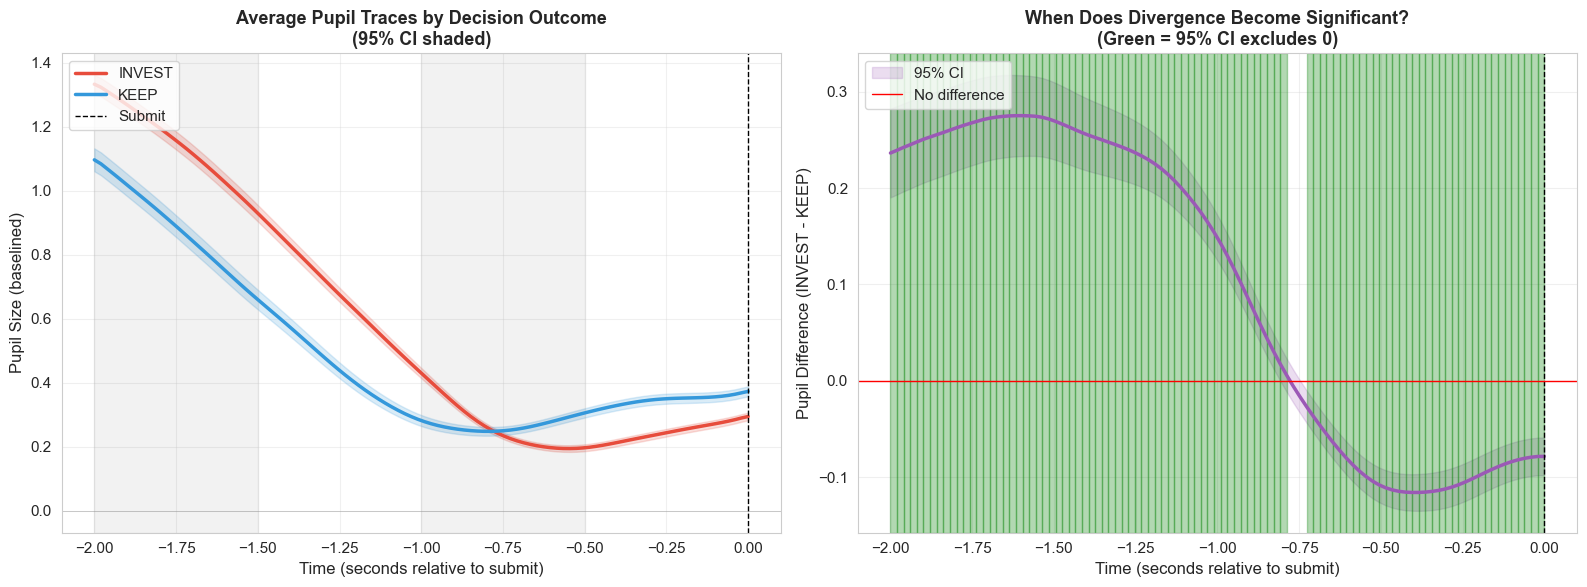

In [16]:
# Plot average traces with confidence intervals
invest_array = np.array(invest_traces)
keep_array = np.array(keep_traces)

invest_mean = np.mean(invest_array, axis=0)
invest_sem = stats.sem(invest_array, axis=0)
keep_mean = np.mean(keep_array, axis=0)
keep_sem = stats.sem(keep_array, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Average traces
ax1 = axes[0]
ax1.plot(TIME_GRID, invest_mean, color='#E74C3C', linewidth=2.5, label='INVEST')
ax1.fill_between(TIME_GRID, invest_mean - 1.96*invest_sem, invest_mean + 1.96*invest_sem, 
                 color='#E74C3C', alpha=0.2)
ax1.plot(TIME_GRID, keep_mean, color='#3498DB', linewidth=2.5, label='KEEP')
ax1.fill_between(TIME_GRID, keep_mean - 1.96*keep_sem, keep_mean + 1.96*keep_sem,
                 color='#3498DB', alpha=0.2)

ax1.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Submit')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Add time bin markers
for i, tb in enumerate(TIME_BINS):
    ax1.axvspan(tb[0], tb[1], alpha=0.1, color='gray' if i % 2 == 0 else 'white')

ax1.set_xlabel('Time (seconds relative to submit)', fontsize=12)
ax1.set_ylabel('Pupil Size (baselined)', fontsize=12)
ax1.set_title('Average Pupil Traces by Decision Outcome\n(95% CI shaded)', fontweight='bold', fontsize=13)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Right plot: Difference trace with significance
ax2 = axes[1]
diff_mean = invest_mean - keep_mean
diff_sem = np.sqrt(invest_sem**2 + keep_sem**2)

ax2.plot(TIME_GRID, diff_mean, color='#9B59B6', linewidth=2.5)
ax2.fill_between(TIME_GRID, diff_mean - 1.96*diff_sem, diff_mean + 1.96*diff_sem,
                 color='#9B59B6', alpha=0.2, label='95% CI')

ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.axhline(y=0, color='red', linestyle='-', linewidth=1, label='No difference')

# Shade where CI doesn't include 0
sig_mask = (diff_mean - 1.96*diff_sem > 0) | (diff_mean + 1.96*diff_sem < 0)
for i in range(len(TIME_GRID)-1):
    if sig_mask[i]:
        ax2.axvspan(TIME_GRID[i], TIME_GRID[i+1], alpha=0.3, color='green')

ax2.set_xlabel('Time (seconds relative to submit)', fontsize=12)
ax2.set_ylabel('Pupil Difference (INVEST - KEEP)', fontsize=12)
ax2.set_title('When Does Divergence Become Significant?\n(Green = 95% CI excludes 0)', fontweight='bold', fontsize=13)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pupil_trace_divergence.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Gaze Temporal Dynamics

**Note**: Gaze temporal dynamics within the PRE-decision window requires raw eye tracking data which is not available. 

The extracted features already contain aggregated gaze metrics for the full PRE-decision window. For within-window temporal analysis, the raw eye tracking data would need to be re-processed.

For now, we'll skip the gaze temporal analysis and focus on the pupil features which show stronger effects.

In [17]:
# Gaze temporal analysis skipped - raw eye tracking data not available
# The gaze features in the extracted features file are already aggregated over the full window
print("Gaze temporal analysis skipped - see note above")

Gaze temporal analysis skipped - see note above


In [18]:
# Placeholder - gaze extraction skipped
gaze_trials_data = []
gaze_df = pd.DataFrame()

In [19]:
# Gaze temporal statistics - skipped
gaze_temporal_df = pd.DataFrame()
print("Gaze temporal statistics skipped - no raw data available")

Gaze temporal statistics skipped - no raw data available


In [20]:
# Gaze heatmap - skipped
print("Gaze heatmap skipped - no raw data available")

Gaze heatmap skipped - no raw data available


## 7. Summary and Findings

In [21]:
# Save all results
temporal_df.to_csv(OUTPUT_DIR / 'within_window_temporal_pupil.csv', index=False)
if len(gaze_temporal_df) > 0:
    gaze_temporal_df.to_csv(OUTPUT_DIR / 'within_window_temporal_gaze.csv', index=False)

# Summary statistics
print("\n" + "="*90)
print("WITHIN-WINDOW TEMPORAL DYNAMICS SUMMARY")
print("="*90)

print(f"\nTotal trials analyzed: {len(df)}")
print(f"Time bins: {len(TIME_BINS)} x {BIN_SIZE}s bins from {WINDOW_START}s to {WINDOW_END}s")

print("\n--- PUPIL FEATURES ---")
print(f"Features analyzed: {len(PUPIL_FEATURES)}")
print(f"Significant effects (p<0.05): {temporal_df['significant'].sum()} / {len(temporal_df)}")
print(f"\nStrongest effect overall:")
strongest = temporal_df.loc[temporal_df['abs_cohens_d'].idxmax()]
print(f"  {strongest['feature']} at {strongest['time_label']}: d = {strongest['cohens_d']:.3f}, p = {strongest['p_value']:.2e}")

if len(gaze_temporal_df) > 0:
    print("\n--- GAZE FEATURES ---")
    print(f"Features analyzed: {len(GAZE_FEATURES)}")
    print(f"Significant effects (p<0.05): {gaze_temporal_df['significant'].sum()} / {len(gaze_temporal_df)}")
    if gaze_temporal_df['abs_cohens_d'].max() > 0:
        strongest_gaze = gaze_temporal_df.loc[gaze_temporal_df['abs_cohens_d'].idxmax()]
        print(f"\nStrongest effect overall:")
        print(f"  {strongest_gaze['feature']} at {strongest_gaze['time_label']}: d = {strongest_gaze['cohens_d']:.3f}, p = {strongest_gaze['p_value']:.2e}")

print("\n" + "="*90)
print("Files saved:")
print(f"  - {OUTPUT_DIR / 'within_window_temporal_pupil.csv'}")
print(f"  - {OUTPUT_DIR / 'within_window_temporal_gaze.csv'}")
print(f"  - {OUTPUT_DIR / 'temporal_evolution_effect_sizes.png'}")
print(f"  - {OUTPUT_DIR / 'temporal_heatmap_all_features.png'}")
print(f"  - {OUTPUT_DIR / 'pupil_trace_divergence.png'}")
print(f"  - {OUTPUT_DIR / 'temporal_heatmap_gaze_features.png'}")
print("="*90)


WITHIN-WINDOW TEMPORAL DYNAMICS SUMMARY

Total trials analyzed: 9483
Time bins: 4 x 0.5s bins from -2.0s to 0.0s

--- PUPIL FEATURES ---
Features analyzed: 18
Significant effects (p<0.05): 41 / 72

Strongest effect overall:
  pupil_mean at -2.0s to -1.5s: d = 0.146, p = 7.59e-12

Files saved:
  - ../../data/results/analysis_outputs_PRE/within_window_temporal_pupil.csv
  - ../../data/results/analysis_outputs_PRE/within_window_temporal_gaze.csv
  - ../../data/results/analysis_outputs_PRE/temporal_evolution_effect_sizes.png
  - ../../data/results/analysis_outputs_PRE/temporal_heatmap_all_features.png
  - ../../data/results/analysis_outputs_PRE/pupil_trace_divergence.png
  - ../../data/results/analysis_outputs_PRE/temporal_heatmap_gaze_features.png


In [22]:
# When does divergence first emerge?
print("\n" + "="*90)
print("EARLIEST SIGNIFICANT DIVERGENCE BY FEATURE")
print("="*90)

earliest_divergence = []
for feature in PUPIL_FEATURES:
    feat_data = temporal_df[(temporal_df['feature'] == feature) & (temporal_df['significant'] == True)]
    if len(feat_data) > 0:
        earliest = feat_data.sort_values('time_start').iloc[0]
        earliest_divergence.append({
            'feature': feature,
            'earliest_significant_bin': earliest['time_label'],
            'cohens_d': earliest['cohens_d'],
            'p_value': earliest['p_value']
        })

earliest_df = pd.DataFrame(earliest_divergence).sort_values('earliest_significant_bin')
print(earliest_df.to_string(index=False))


EARLIEST SIGNIFICANT DIVERGENCE BY FEATURE
                    feature earliest_significant_bin  cohens_d      p_value
          eye_asymmetry_std            -0.5s to 0.0s -0.076487 3.259317e-04
              eye_asymmetry           -1.0s to -0.5s -0.052587 1.346269e-02
          pct_time_dilating           -1.5s to -1.0s -0.117035 3.875768e-08
     pupil_acceleration_std           -1.5s to -1.0s  0.060934 4.191863e-03
    pupil_acceleration_mean           -1.5s to -1.0s  0.066454 1.792260e-03
pupil_max_constriction_rate           -1.5s to -1.0s  0.124812 4.599335e-09
         pupil_velocity_std           -1.5s to -1.0s  0.093803 1.050021e-05
    pupil_max_dilation_rate           -1.5s to -1.0s -0.053167 1.247074e-02
                pupil_slope           -1.5s to -1.0s -0.119670 1.909583e-08
                pupil_range           -1.5s to -1.0s  0.109989 2.391355e-07
                  pupil_std           -1.5s to -1.0s  0.107672 4.251207e-07
        pupil_velocity_mean           -1.5s 